# **Facets tutorial**
One of the most sofisticated transformations that Pyoskar provides us is [<span style="color:#FF1493"> **facet** </span>]. As every transformation it pertains to Oskar class and we can acces to it through our Oskar instance.
<br>
Usage:
```
facet(df[DataFrame], facet[str])
```

We have to to import both Spark and Oskar APIs, as well as loading our data into a spark DataFrame:

In [3]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import col, udf, count, explode, concat, when, expr
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("/home/roldanx/appl/oskar/oskar-spark/src/test/resources/platinum_chr22.small.parquet")

## Simple facets
Now that we have loaded our data, we start with an easy facet. This example executes the classics "groupBy" and "count" upon our dataframe. The next format was designed to be applied on categorical or discrete quantitative variants. That could be any among these: 
 - Chromosome [<span style="color:#ff6600"> **chromosome** </span>]
 - Variant type [<span style="color:#ff6600"> **type** </span>]
 - Studies [<span style="color:#ff6600"> **studies** </span>]
 - Biotype [<span style="color:#ff6600"> **biotype** </span>]
 - Consequence type [<span style="color:#ff6600"> **ct** </span>]
 - Gene [<span style="color:#ff6600"> **gene** </span>]
 - Ensemble gene ID [<span style="color:#ff6600"> **ensemblGeneId** </span>]
 - Ensemble gene transcript [<span style="color:#ff6600"> **ensemblTranscriptId** </span>]

In [5]:
oskar.facet(df, "type").show()

+-----+-----+
| type|count|
+-----+-----+
|INDEL|  106|
|  SNV|  894|
+-----+-----+



In [40]:
oskar.facet(df, "ct").show(truncate=False)

+----------------------------------+-----+
|ct                                |count|
+----------------------------------+-----+
|2KB_downstream_variant            |146  |
|2KB_upstream_variant              |146  |
|3_prime_UTR_variant               |9    |
|5_prime_UTR_variant               |1    |
|NMD_transcript_variant            |140  |
|TF_binding_site_variant           |108  |
|downstream_gene_variant           |163  |
|intergenic_variant                |222  |
|intron_variant                    |543  |
|missense_variant                  |4    |
|non_coding_transcript_exon_variant|45   |
|non_coding_transcript_variant     |385  |
|regulatory_region_variant         |764  |
|splice_donor_variant              |1    |
|splice_region_variant             |2    |
|synonymous_variant                |6    |
|upstream_gene_variant             |200  |
+----------------------------------+-----+



## Include facets
We can also applies a filtering based on the values we explicit in the function:

In [41]:
oskar.facet(df, "gene[BCL2L13,CECR2]").show()

+-------+-----+
|   gene|count|
+-------+-----+
|BCL2L13|    8|
|  CECR2|   11|
+-------+-----+



## Range facets
Using a similar syntax as with "Include facets" but dealing with continuous quantitative we find that we can apply facets by range, where we can determine both upper and downer thresholds as well as the step e.g. [start..end]:step. Available range fields:
 - Conservation scores: grep [<span style="color:#ff6600"> **grep** </span>], phylop [<span style="color:#ff6600"> **phylop** </span>] or phastCons [<span style="color:#ff6600"> **phastCons** </span>]
 - Functional scores: cadd_scaled [<span style="color:#ff6600"> **cadd_scaled** </span>] or cadd_raw [<span style="color:#ff6600"> **cadd_raw** </span>]
 - Substitution scores: sift [<span style="color:#ff6600"> **sift** </span>] or polyphen [<span style="color:#ff6600"> **polyphen** </span>]

In [44]:
oskar.facet(df, "phylop[-5..0]:1").show()

+-----------+-----+
|phylopRange|count|
+-----------+-----+
|       -4.0|    3|
|       -3.0|   12|
|       -2.0|   55|
|       -1.0|  171|
|        0.0|  681|
+-----------+-----+



Furthermore, we dispose two more rangeable fields where we could use our facets. These ones have the peculiarity that they need extra inputs to be fully defined; we will need to explicit the study which they pertain and the cohort delimited by two underscores. These fields are:
 - Global alternate population frequency [<span style="color:#ff6600"> **popFreq** </span>] 
 - Dataframe alternate population frequency [<span style="color:#ff6600"> **stats** </span>], which is included in the dataframe stats field.

In [123]:
oskar.facet(df, "popFreq__GNOMAD_GENOMES__ALL[0..1]:0.1").show()

+---------------------------------+-----+
|popFreq__GNOMAD_GENOMES__ALLRange|count|
+---------------------------------+-----+
|                              0.0|  514|
|                              0.1|  112|
|                              0.2|   75|
|              0.30000000000000004|   97|
|                              0.4|   77|
|                              0.5|   26|
|               0.6000000000000001|   35|
|               0.7000000000000001|   23|
|                              0.8|   18|
|                              0.9|   15|
|                              1.0|    8|
+---------------------------------+-----+



In case we want to get the dataframe alternate population frequency, first we will need to fill the stats field as explained in the "stats" tutorial:

In [9]:
samples = oskar.metadata.samples(df)["hgvauser@platinum:illumina_platinum"]
df2 = oskar.stats(df,studyId="hgvauser@platinum:illumina_platinum",cohort="ALL",samples=samples)
oskar.facet(df2, "stats__hgvauser@platinum:illumina_platinum__ALL[0..1]:0.1").show()

+----------------------------------------------------+-----+
|stats__hgvauser@platinum:illumina_platinum__ALLRange|count|
+----------------------------------------------------+-----+
|                                                 0.0|   41|
|                                                 0.1|   15|
|                                                 0.2|   14|
|                                 0.30000000000000004|   10|
|                                                 0.4|    7|
|                                                 0.5|  714|
|                                  0.6000000000000001|   68|
|                                  0.7000000000000001|   49|
|                                                 0.8|   12|
|                                                 0.9|   21|
|                                                 1.0|   48|
+----------------------------------------------------+-----+



## Aggregation facets
We may want to check whether the compounds of all variants have historically been well conservated or otherways have notably evolved. For this task we could use the aggregation facets, with substitutes the default "count" function for another one we decide among this ones:
 - Average [<span style="color:#ff6600"> **avg** </span>]
 - Maximum [<span style="color:#ff6600"> **max** </span>]
 - Minimum [<span style="color:#ff6600"> **min** </span>]
 - Sumatory [<span style="color:#ff6600"> **sum** </span>]
 - Squared sumatory [<span style="color:#ff6600"> **sumsq** </span>]
 - Standard deviation [<span style="color:#ff6600"> **stddev** </span>]
 - Variance [<span style="color:#ff6600"> **var** </span>]
 - Percentile values [<span style="color:#ff6600"> **percentile** </span>]
 - Set of values [<span style="color:#ff6600"> **unique** </span>]

In [16]:
oskar.facet(df, "avg(gerp)").show(truncate=False)

+-------------------+-----+
|          avg(gerp)|count|
+-------------------+-----+
|-0.3518712293113349| 1000|
+-------------------+-----+



In [162]:
oskar.facet(df, "percentile(gerp)").show(truncate=False)

+---------------------------------------------------------------------------------------+-----+
|percentile(gerp)                                                                       |count|
+---------------------------------------------------------------------------------------+-----+
|[-2.152000093460083, -0.6257500052452087, 0.0, 0.14900000393390656, 0.7430999755859375]|1000 |
+---------------------------------------------------------------------------------------+-----+



## Nested facets
The last feature we find available for our facet queries is nesting, which allows us to concatenate gruops and reach complex studies by using ">>" separator.

In [52]:
oskar.facet(df, "biotype>>ct[splice_donor_variant]").show(truncate=False)

+-----------------------+--------------------+-----+
|biotype                |ct                  |count|
+-----------------------+--------------------+-----+
|nonsense_mediated_decay|splice_donor_variant|1    |
|processed_transcript   |splice_donor_variant|1    |
|protein_coding         |splice_donor_variant|1    |
|retained_intron        |splice_donor_variant|1    |
+-----------------------+--------------------+-----+



## Final facets
Now it is up to us to mix all these ingredients:

In [122]:
oskar.facet(df, "gene[AIFM3,GGT1]>>biotype>>cadd_raw[-10..10]:0.2>>cadd_scaled[-10..10]:1>>min(phylop)").show(25, truncate=False)

+-----+-----------------------+-------------+----------------+--------------------+-----+
|gene |biotype                |cadd_rawRange|cadd_scaledRange|min(phylop)         |count|
+-----+-----------------------+-------------+----------------+--------------------+-----+
|AIFM3|lincRNA                |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|nonsense_mediated_decay|0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|processed_transcript   |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|protein_coding         |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|retained_intron        |0.2          |6.0             |-0.2809999883174896 |1    |
|GGT1 |nonsense_mediated_decay|-0.2         |0.0             |-1.1380000114440918 |2    |
|GGT1 |nonsense_mediated_decay|0.0          |1.0             |0.10199999809265137 |2    |
|GGT1 |nonsense_mediated_decay|0.0          |2.0             |0.054999999701976776|1    |
|GGT1 |non

In [96]:
snvPandas = oskar.facet(df, "type[SNV]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").show()
indelPandas = oskar.facet(df, "type[INDEL]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").show()

+----+---------------------------------+-----+
|type|popFreq__GNOMAD_GENOMES__ALLRange|count|
+----+---------------------------------+-----+
| SNV|                              0.0|  478|
| SNV|                              0.1|   95|
| SNV|                              0.2|   57|
| SNV|              0.30000000000000004|   90|
| SNV|                              0.4|   66|
| SNV|                              0.5|   21|
+----+---------------------------------+-----+

+-----+---------------------------------+-----+
| type|popFreq__GNOMAD_GENOMES__ALLRange|count|
+-----+---------------------------------+-----+
|INDEL|                              0.0|   36|
|INDEL|                              0.1|   17|
|INDEL|                              0.2|   18|
|INDEL|              0.30000000000000004|    7|
|INDEL|                              0.4|   11|
|INDEL|                              0.5|    5|
+-----+---------------------------------+-----+



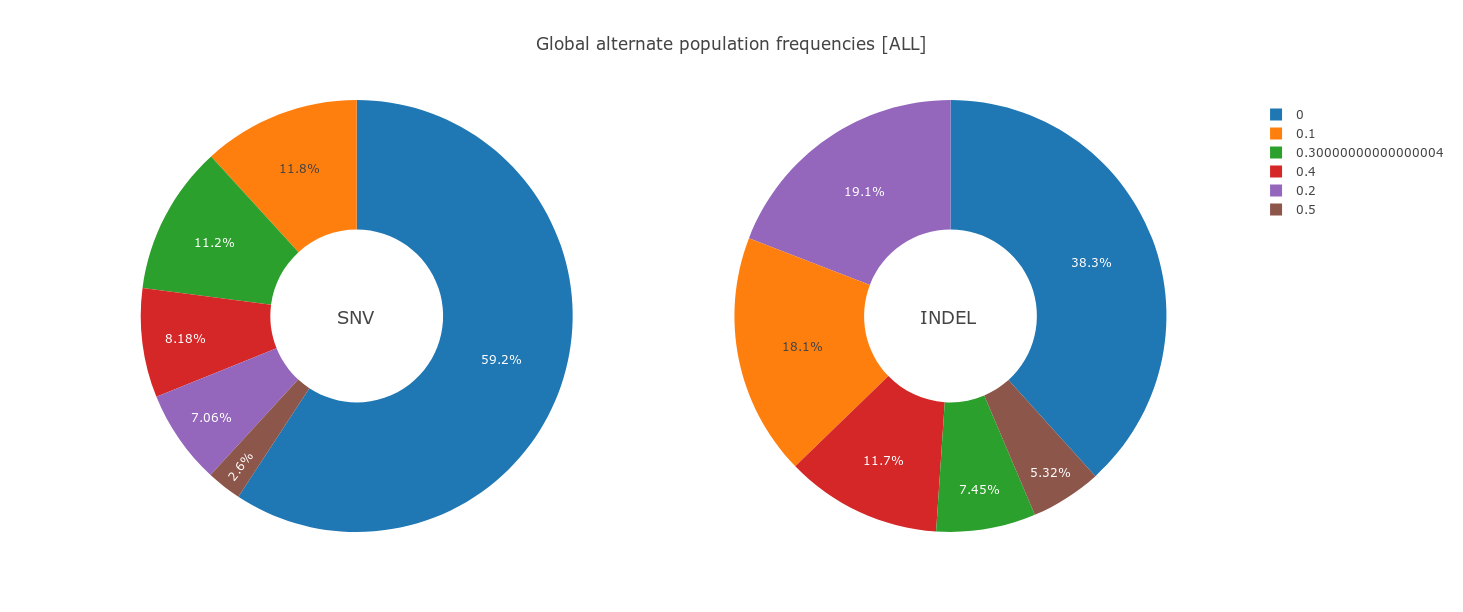

In [7]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import get_plotlyjs, init_notebook_mode

snvPandas = oskar.facet(df, "type[SNV]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").toPandas()
indelPandas = oskar.facet(df, "type[INDEL]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").toPandas()

init_notebook_mode(connected=True)

fig = {
  "data": [
    {
      "values": snvPandas["count"],
      "labels": snvPandas["popFreq__GNOMAD_GENOMES__ALLRange"],
      "domain": {"x": [0, .48]},
      "hole": .4,
      "type": "pie"
    },
    {
      "values": indelPandas["count"],
      "labels": indelPandas["popFreq__GNOMAD_GENOMES__ALLRange"],
      "domain": {"x": [.51, 1]},
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Global alternate population frequencies [ALL]",
        "autosize":False,
        "width":1500,
        "height":600,
        "annotations": [
            {
                "font": {
                    "size": 18
                },
                "showarrow": False,
                "text": "SNV",
                "x": 0.22,
                "y": 0.5
            },
            {
                "font": {
                    "size": 18
                },
                "showarrow": False,
                "text": "INDEL",
                "x": 0.78,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig, filename='donut')